In [105]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
import pandas as pd

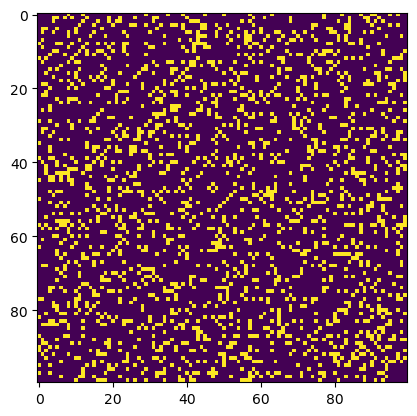

In [338]:
n = 100
dt = 0.001
T = 1

# # default, connected
# A = np.ones((n,n))
# A = np.triu(A, 1)
# A = A + A.T

# Erdos Renyi
p = .2
A = np.random.rand(n,n) # random matrix
A = np.where(A < p, 1, 0) # adjacency matrix
A = np.triu(A, 1) # triangular matrix
A = A + A.T # symmetric matrix

# # Small World
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             continue
#         if np.abs(i-j) < 5:
#             A[i,j] = 1
#         elif np.abs(i-j) > n-5:
#             A[i,j] = 1
#         else:
#             A[i,j] = 0

# plot

#Simulating for the Barbell Population Model with a Stopping Criterion
# pop = np.random.randint(25,75) #minimum and maximum population sizes
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             A[i,j] = 0
#         elif (i <= pop and j <= pop) or (i > pop and j > pop):
#             A[i,j] = 1
#         else:
#             A[i,j] = 0
# sender = np.random.randint(0,pop+1)
# receiver = np.random.randint(pop+1,99)
# A[sender,receiver] = 1
# A[receiver,sender] = 1

plt.imshow(A)
plt.show()

## Second Approach to Accumulation of Private Information

$\frac{dy_j}{dt} = \pm \mu dt + \sqrt{2\mu}dW_j(t) + \frac{dL(t)}{dt}$, where $L(t) = \ln(\frac{P(H_+)}{P(H_-)})$ at time t, where the $P(H_+)$ and $P(H_-)$ are given by a logistic classification model built on previous rounds of training samples.

In [378]:
# Creating a set of uniformly distributed thresholds that lie between a minimum and maximum threshold, dealer's choice for how wide this interval is
thresh = np.array([np.random.uniform(0.25,0.75) for i in range(n)])
T = 1
per = 10

# initial conditions
y = np.zeros((n, int(T/dt)))

# Simulating a run of the agents
def sim(y0,Adj,thetas,mu,period,N,Time,delta_t,stop,model = False):
    kicks = np.zeros(N) #Easy way to tell when some agent has kicked
    neighbors = np.zeros(N) #This is going to be a weighted average of the thresholds of the neighbors that have decided
    train = [] #Training data for the model
    # simulation
    for t in range(1,int(Time/delta_t)-1):
        neighbors = []
        for j in range(N): #This function here is going through and finding whether a decision has been made by a neighbor
            #Using the adjacency matrix, and then summing up the thresholds multiplied by the decision that was made (1,-1,0)
            #Then, to form the average, this weighted sum is divided by the total number of neighbors nearby
            B = []
            for i in range(N):
                if kicks[i] < 0:
                    B+= [max(-1,Adj[i,j]*kicks[i])]
                elif kicks[i] > 0:
                    B += [min(1,Adj[i,j]*kicks[i])]
                else:
                    B += [0]
            NoComm = list(Adj[:,j]).count(0)
            neighbors += [B@thetas/(N-NoComm)]

        if t%period == 0: #Set a period along which you want training samples to be collected
            train += [[t,neighbors]]
            
        # update state
        LLR = np.zeros(n)
        if model: #If we actually have a model to use to form a Log-Likelihood ratio, then you need to predict the correct decision
            for m in range(N):
                res = model.predict_proba(np.array([neighbors[m]]).reshape(-1,1))[0]
                LLR[m] = np.log(res[1]/res[0])
                #if res[0] > res[1]:
                 #   LLR[m] = -1*res[0]
                #elif res[1] > res[0]:
                 #   LLR[m] = res[1]
                #else:
                 #   LLR[m] = 0
        #else:
         #   LLR[m] = neighbors[m]
        # Update Kicks and The State
        cnt = 0
        for yj in range(N):
            y0[yj,t] = y0[yj,t-1] + delta_t*mu + np.sqrt(2*abs(mu)*dt)*np.random.normal(0.0,1)+LLR[yj]*dt
                
            if y0[yj,t] <= -1*thetas[yj]: #If the new predicted information for an agent is outside of their threshold
                #Then they make a decision, and they're registered as having "kicked"
                y0[yj,t] = -1
                kicks[yj] = -1
                cnt += 1 #Adding the total number of people who have decided in favor of H-
            elif y0[yj,t] >= thetas[yj]:
                y0[yj,t] = 1
                kicks[yj] = 1
                cnt += 1 #Adding the total number of people who have decided in favor of H+
            else:
                kicks[yj] = 0
                
        if cnt >= stop: #If a certain threshold of people have decided, then end the sim
            break

    #print(kicks)
    return train,y0,t #This returns  a training dataset, the simulated behavior, and the time the sim ended

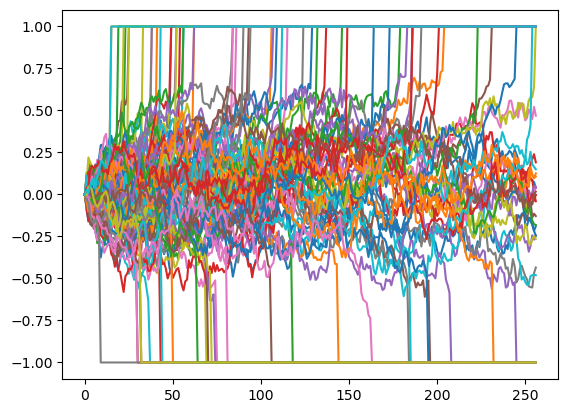

In [379]:
training,ysim,tstop = sim(y,A,thresh,1,per,n,1,dt,80,model = False)
for i in range(n):
    plt.plot(ysim[i,:tstop+1])
plt.show()

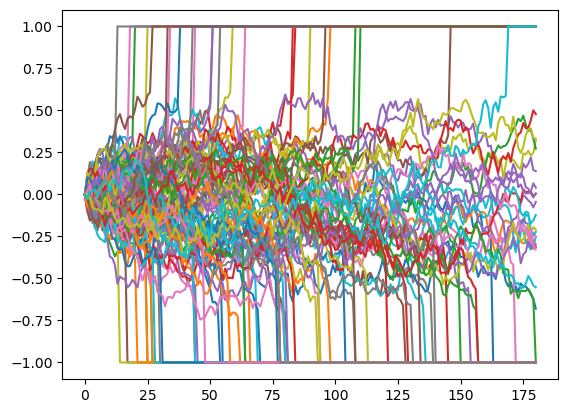

In [369]:
training2,ysim2,tstop2 = sim(y,A,thresh,-1,10,100,1,0.001,80,model=False)
for i in range(n):
    plt.plot(ysim2[i,:tstop2+1])
plt.show()

In [380]:
def RR(yvec,correct,tstop): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = 0
    inc = 0
    und = 0
    for i in yvec:
        if i == correct:
            cor += 1
        elif i == -1*correct:
            inc += 1
        else:
            und += 1
    return (cor/(inc+und+cor))/tstop

RR(ysim2[:,tstop2],-1,tstop2)

0.0031111111111111114

In [381]:
RR(ysim[:,tstop],1,tstop)

0.0020703125

In [382]:
# kicks = [1,-1,0,1,-1,1,1,-1,0,0,0,1,-1,-1,1,-1,1,1,-1-1,-1,0,-1,0,1,-1,1,1,1,-1,-1,-1,1,1,-1,0,1,0,0,0,-1,1,-1,-1,0,-1,0,0,0,0,-1,-1,0,-1,-1,1,0,-1,1,-1,-1,-1,0,0,0,0,0,0,0,1,1,1,1,
#  -1,-1,0,0,1,0,-1,1,0,1,0,1,-1,1,0,-1,0,-1,-1,0,-1,0,1,0,-1,1,1,0]
# for i in range(n):
#     if kicks[i] < 0:
#         B[i] = max(-1,A[i,1]*kicks[i])
#     elif kicks[i] > 0:
#         B[i] = min(1,A[i,1]*kicks[i])
#     else:
#         B[i] = 0
df = []
for i in training:
    df += i[1]
for i in training2:
    df+= i[1]
    
df = pd.DataFrame({'Aggregate':df,'True':np.array(len(df)//2*[1]+len(df)//2*[-1])})
X = np.array(df['Aggregate']).reshape(-1, 1)
ydat = df['True']
logreg = LogisticRegression()
logreg.fit(X, ydat)

LogisticRegression()

In [383]:
res = logreg.predict_proba(np.array([0.25,0.30,-0.1,-0.2]).reshape(-1,1))
res

array([[0.09986407, 0.90013593],
       [0.06462591, 0.93537409],
       [0.7533261 , 0.2466739 ],
       [0.88731678, 0.11268322]])

In [384]:
LLR = []
for i in res:
    LLR += [np.log(i[0]/i[1])]
LLR

[-2.1987358467926974,
 -2.6723311068134072,
 1.1164309733522604,
 2.0636214933936765]

In [385]:
logreg.predict(np.array([0.25,0.30,-0.1,-0.2]).reshape(-1,1))

array([ 1,  1, -1, -1])

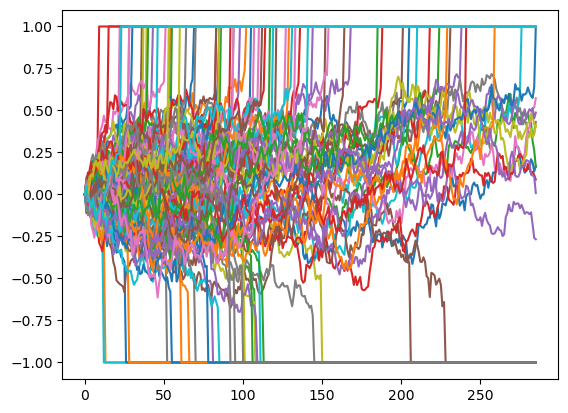

In [386]:
training3,ysim3,tstop3 = sim(np.zeros((100, int(1/0.001))),A,thresh,1,10,100,1,0.001,90,model = logreg)
for i in range(n):
    plt.plot(ysim3[i,:tstop3+1])
plt.show()

In [388]:
RR(ysim3[:,tstop3],1,tstop3)

0.002245614035087719

In [364]:
tstop3

2

0.023125